index
*load data
*check data is randomly split
*confirm conversion is same/diff in control and expriment 
*find out # of days for experiment for statistical significant

In [350]:

#data read from input file 
import numpy as np
import pandas as pd
from scipy import stats


input_test_file='data/Pricing_Test/test_results.csv'
input_user_file='data/Pricing_Test//user_table.csv'
testdata=pd.read_csv(input_test_file)
userdata=pd.read_csv(input_user_file)

In [351]:
testdata.head()
testdata.shape
#testdata.groupby("price").size()

(316800, 8)

In [352]:
userdata.head()
#userdata.groupby("city").size()#all users are in USA, in different cities 


,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


In [353]:
#check uniqueness of user id in both table
max(testdata.groupby("user_id").size())
max(userdata.groupby("user_id").size())

1

In [354]:
#check different group conversion rate 
testdata.groupby("test")["converted"].mean()

test
0    0.019904
1    0.015543
Name: converted, dtype: float64

In [355]:
import seaborn as sns
import matplotlib.pyplot as plt

In [356]:
data=testdata.merge(userdata,how="left",on="user_id")

In [357]:
data.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02


In [358]:
#data validation
data.groupby(["test","operative_system"]).size()
#data.groupby(["test"]).size()

test  operative_system
0     android             48210
      iOS                 61855
      linux                2207
      mac                 16366
      other               10498
      windows             63591
1     android             26725
      iOS                 33610
      linux                1928
      mac                  8719
      other                5706
      windows             37385
dtype: int64

In [359]:
#data validation
os_by_test_ctrl = data.groupby('test')['operative_system'].apply(lambda s: s.value_counts(normalize=True)).unstack()
os_by_test_ctrl
#it is calculating OS distribution among a group (control group or experiment group)

,windows,iOS,android,mac,other,linux
test,,,,,,
0,0.313678,0.305115,0.237807,0.080729,0.051784,0.010887
1,0.327729,0.294636,0.234280,0.076434,0.050021,0.016901


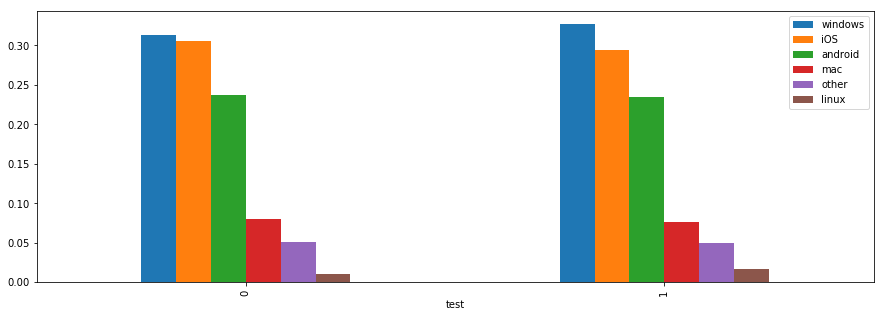

In [360]:
os_by_test_ctrl.plot(kind='bar',figsize=(15,5))
plt.show()

In [361]:
from sklearn.feature_selection import chi2,f_classif

check features are independent from test/non test group 

In [362]:

X = testdata.copy()
del X['timestamp']

X.rename(columns={'operative_system':'OS'},inplace=True)

# to use sklearn to check feature importance, we must convert string values to numbers
src_label_encoder = LabelEncoder()
dev_label_encoder = LabelEncoder()
os_label_encoder = LabelEncoder()

X["source"] = src_label_encoder.fit_transform(testdata.source)
X["device"] = dev_label_encoder.fit_transform(testdata.device)
X["OS"] = os_label_encoder.fit_transform(testdata.operative_system)

Chi squared test


In [363]:
colnames = ["source","device","OS"]
ch2values,pvalues = chi2(X.loc[:,colnames],X["test"])
pd.DataFrame({'chi2_value':ch2values,'pvalue':pvalues},index = colnames).sort_values(by='pvalue')

,chi2_value,pvalue
OS,83.085986,7.856065e-20
device,44.366335,2.723301e-11
source,0.924742,3.362329e-01


In [364]:
#Compute pairwise correlation of columns, excluding NA/null values
X.corr()
testdata.corr()

,user_id,test,price,converted
user_id,1.000000,0.000525,0.000645,0.001684
test,0.000525,1.000000,0.997500,-0.015604
price,0.000645,0.997500,1.000000,-0.015456
converted,0.001684,-0.015604,-0.015456,1.000000


from above result, we know that the splitting between test/control groups aren't random. OS and device has great impact on the split.

In [365]:
#data validation
data.groupby(["test","price"]).size()

test  price
0     39       202517
      59          210
1     39          155
      59       113918
dtype: int64

In [366]:
#remove records with inconsistent labels 
data=data[((data["test"]==1)&(data["price"]==59))|((data["test"]==0)&(data["price"]==39))]
data["Rev"]=data["price"]*data["converted"]

data1=data #used as data acrhive
data=data1 #change data back to all records 

#data.groupby(["test","price"]).size()

In [367]:
#another method to calculate revenue, a case to use group by, and how to calculated other attributes from it
revenues = data.groupby(by="test").apply(lambda df: df.price * df.converted)
def group_statistics(df):
    return pd.Series({'n_users': df.shape[0],
                      'convert_rate': df.converted.mean(), 
                      'mean_revenue': (df.price * df.converted).mean()})
data.groupby('test').apply(group_statistics)

,convert_rate,mean_revenue,n_users
test,,,
0,0.019900,0.776083,202517.0
1,0.015555,0.917748,113918.0


Question 1: Should the company sell its software for $39 or $59? 

In [368]:
data_low=data[data["test"]==0]
data_high=data[data["test"]==1]
data_low.head()
data_high.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long,Rev
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90,0
7,798371,2015-03-15 08:19:29,ads-bing,mobile,android,1,59,1,East Orange,USA,40.77,-74.21,59
8,447194,2015-03-28 12:28:10,ads_facebook,web,windows,1,59,0,Dayton,USA,39.78,-84.20,0
9,431639,2015-04-24 12:42:18,ads_facebook,web,windows,1,59,0,Richmond,USA,37.53,-77.47,0
15,552048,2015-03-22 08:58:32,ads-bing,web,windows,1,59,0,Culver City,USA,34.01,-118.40,0


In [369]:
print(data[["test","converted"]].groupby("test").mean())
stats.ttest_ind(data_low["converted"],data_high["converted"])

#diff is significant, then reject null hypothesis 
#accept alternative hypothesis, which is when raising price, convert ratio will be lower

      converted
test           
0      0.019900
1      0.015555


Ttest_indResult(statistic=8.744781828681587, pvalue=2.2450851601497147e-18)

we are going to perform a t-test to test whether the test group's average revenue is higher than control group's average revenue

H0: test group's average revenue equal to control group's average revenue
HA: test group's average revenue is higher than control group's average revenue

In [370]:
print(data[["test","Rev"]].groupby("test").mean())
ttest_result=stats.ttest_ind(data_low["Rev"],data_high["Rev"])

# since our HA is test_mean > ctrl_mean, so we need to divide by 2
ttest_result.pvalue/2


#diff is significant 

           Rev
test          
0     0.776083
1     0.917748


2.9947980268470946e-10

In [371]:
# Check randominess
tmp = data.groupby('test')['operative_system'].apply(lambda x: x.value_counts(normalize=True)).unstack()
tmp


,windows,iOS,android,mac,other,linux
test,,,,,,
0,0.313638,0.305125,0.237891,0.080709,0.051754,0.010883
1,0.327718,0.294598,0.234318,0.076459,0.050001,0.016907


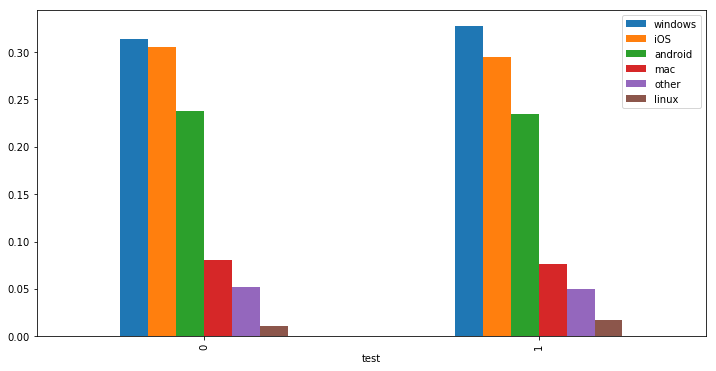

In [372]:
fig, ax = plt.subplots(figsize=(12, 6))
tmp.plot(kind='bar', ax=ax)
plt.show()

Question 2: 
The VP of Product is interested in having a holistic view into user behavior, especially focusing on actionable insights that might increase conversion rate. What are your main ﬁndings looking at the data? 

In [373]:
data.head()

from datetime import datetime  
from datetime import timedelta  
 

In [374]:
#data engineer 
from datetime import datetime  
from datetime import timedelta  

#data["timestamp"].max()#exp is lasting for 3 months 
data["month"]=data["timestamp"].apply(lambda x:int(x[5:-12]))

In [375]:
#focus on test group, conversion ratio 
data=data[data["test"]==1]
 

In [377]:
'''
#re-sampling data
#technique: OVER-sampling
con_no_count,con_yes_count=data["converted"].value_counts()

convert_yes=data[data["converted"]==1]
convert_no=data[data["converted"]==0]
convert_yes_over=convert_yes.sample(int(con_no_count/2),replace=True)
 
data_new=convert_yes_over.append(convert_no)
print(data.groupby("converted").size())
print(data_new.groupby("converted").size())
data=data_new
'''


'\n#re-sampling data\n#technique: OVER-sampling\ncon_no_count,con_yes_count=data["converted"].value_counts()\n\nconvert_yes=data[data["converted"]==1]\nconvert_no=data[data["converted"]==0]\nconvert_yes_over=convert_yes.sample(int(con_no_count/2),replace=True)\n \ndata_new=convert_yes_over.append(convert_no)\nprint(data.groupby("converted").size())\nprint(data_new.groupby("converted").size())\ndata=data_new\n'

In [378]:

#encode for source, device, operative_system, city
from sklearn.preprocessing import LabelEncoder
le1=LabelEncoder()
le2=LabelEncoder()
le3=LabelEncoder()


mldata=data[["month"]]
mldata['source']=le1.fit_transform(data["source"])
mldata['device']=le2.fit_transform(data['device'])
mldata['operative_system']=le3.fit_transform(data['operative_system'])

label=data["converted"]
mldata.head()


C:\Users\shanchen\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\shanchen\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\ipykernel\__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\shanchen\AppData\Local\Enthought\Canopy\edm\envs\User\lib\site-packages\ipykernel\__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

,month,source,device,operative_system
3,5,5,0,1
7,3,0,0,0
8,3,3,1,5
9,4,3,1,5
15,3,0,1,5


In [379]:
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

clf=DecisionTreeClassifier(class_weight="balanced")
X_train, X_test, y_train, y_test = train_test_split(mldata, label, test_size=0.7)



In [380]:
pd.DataFrame(y_train)["converted"].mean()#0.016
pd.DataFrame(y_test)["converted"].mean()#0.015
 

pd.DataFrame(y_pred)[0].mean()
#X_test
#y_train

0.081695738573636559

In [382]:
clf=clf.fit(X=X_train,y=y_train)
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

#when use over-sampling method, accuracy is about 67.55%
#when do not use over sampling method, accuracy is about 97%, however precision is 0, recall is 0
#when use DecisionTreeClassifier(class_weight="balanced"), accuracy is 53.36%

Accuracy: 53.36%


In [383]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
tn, fp, fn, tp = conf_mat.ravel()
print('Confusion matrix:\n', conf_mat)
print(tn,fp,fn,tp)

Confusion matrix:
 [[41837 36670]
 [  522   714]]
41837 36670 522 714


without over sampling for converted records, this classification tree predict nothing to be converted. which is precision =0, and recall=0, this is not right;
with over sampling for converted records, precision is slightly over 50%, and recall is just 13%, which is not good either

In [283]:
#calculate feature importance 
importance=clf.feature_importances_
features=list(X_train.columns)

importances = sorted(zip(features, importance), key=lambda x:x[1], reverse=True)
for feature, val in importances:
    print('{0:10s} | {1:.5f}'.format(feature, val))

source     | 0.54614
operative_system | 0.23876
month      | 0.15616
device     | 0.05894


# Question 1 Insights:
although this model performance is bad, but we can still learn something from it.
source is most important feature to drive conversion. 


In [302]:

converted_by_source= data.groupby("source")['converted'].apply(lambda s: s.value_counts(normalize=True)).unstack()
converted_by_source

,0,1
source,,
ads-bing,0.767309,0.232691
ads-google,0.614378,0.385622
ads-yahoo,0.746783,0.253217
ads_facebook,0.647316,0.352684
ads_other,0.714168,0.285832
direct_traffic,0.757884,0.242116
friend_referral,0.471957,0.528043
seo-bing,0.701571,0.298429
seo-google,0.660586,0.339414


#question 1 do not use label encoder, use get dummies to do a prediction tree

In [308]:

datav2=testdata
datav2.head()
del datav2["user_id"]
del datav2["timestamp"]
del datav2["test"]
datav2.head()


,source,device,operative_system,price,converted
0,ads_facebook,mobile,iOS,39,0
1,seo-google,mobile,android,39,0
2,ads-bing,mobile,android,39,0
3,direct_traffic,mobile,iOS,59,0
4,ads_facebook,web,mac,39,0


In [338]:
datav2 = pd.get_dummies(datav2)
datav2.head()

datav2_features=datav2.loc[:,datav2.columns!="converted"]
datav2_label=datav2["converted"]


clf2=DecisionTreeClassifier(max_depth=4)
X2_train, X2_test, y2_train, y2_test = train_test_split(datav2_features, datav2_label, test_size=0.7)

In [339]:
clf2.fit(X2_train,y2_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [349]:
from sklearn.externals.six import StringIO  
import pydot 
from IPython.display import Image  
from sklearn.tree import export_graphviz
from sklearn import tree
 
dot_data = StringIO() 

 
tree.export_graphviz(clf2, out_file=dot_data,
                    feature_names = datav2_features.columns, 
                    rounded = False, proportion = True, 
                    precision = 2, filled = True) 

graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
 
graph[0].write_pdf("6pricing_decisiontree.pdf") 
#this chart is displaying gini impurity. When this node contains a single 

True

by checking the decision tree, we can see for the highest conversion (which is about 4.3%~4.6%), it should be friend referal + iOs, therefore marketing team should spend more efforts to increase motivation for referral, and promote within iOS users. 

# Bonus Question

[Bonus] The VP of Product feels that the test has been running for too long and he should have been able to get statistically signiﬁcant results in a shorter time. Do you agree with her intuition? After how many days you would have stopped the test? Please, explain why.


In [133]:
#bonus question
#how many records are enough to make a conclusion, or how many of days this experiment should run

from datetime import datetime  
from datetime import timedelta  

#date conversion from string to 
start=datetime.strptime((data["timestamp"].min()), '%Y-%m-%d %H:%M:%S')#min=2015-3-2, max=2015-5-31




#use a loop to calculate number of days 
for i in range(12):
    #print(i)    
    cutoff=start+timedelta(days=i)    
    data_tmp=data[data["timestamp"]<=cutoff.strftime("%Y-%m-%d %H:%M:%S")]
    #print(data_tmp["timestamp"].max())
     
    data_low=data_tmp[data_tmp["test"]==0]
    data_high=data_tmp[data_tmp["test"]==1]
    
    #stats,pvalue=
    pvalue=stats.ttest_ind(data_low["converted"],data_high["converted"]).pvalue
    if pvalue<0.05:
        break

print ("If I need to confirm test group conversion is lower, i need p values <0.05, I need minimal {0} days, with p value equal to={1}".format(str(j),"{:.2%}".format(pvalue)))

for j in range(10):     
    cutoff=start+timedelta(days=j)    
    data_tmp=data[data["timestamp"]<=cutoff.strftime("%Y-%m-%d %H:%M:%S")]
     
    data_low=data_tmp[data_tmp["test"]==0]
    data_high=data_tmp[data_tmp["test"]==1]
    
    pvalue=stats.ttest_ind(data_low["Rev"],data_high["Rev"]).pvalue
    if pvalue<0.05:
        break

print ("If I need to confirm test group rev is higher, i need p values <0.05, I need minimal {0} days, with p value equal to={1}".format(str(j),"{:.2%}".format(pvalue)))
 




If I need to confirm test group conversion is lower, i need p values <0.05, I need minimal 6 days, with p value equal to=1.70%
If I need to confirm test group rev is higher, i need p values <0.05, I need minimal 6 days, with p value equal to=2.59%


In [1]:
#test shared onto GitHub